# Variability analysis

An important tool in analyzing the behavior of computational models is analyzing the sensitivity of results to parameter changes. Metabolic Control Analysis (MCA) provides tools for analyzing the effects of such changes on the steady state of the model.

In [7]:
import roadrunner
%matplotlib inline
roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, False)

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

We are interested in the effects of parameters for a given simulation scenario. The analysed scenario is simple simulation to steady state.

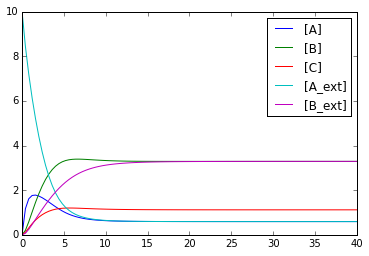

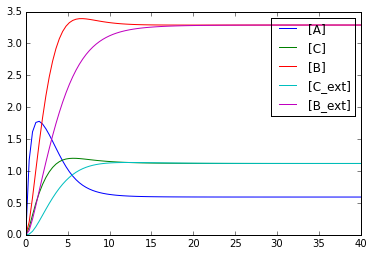

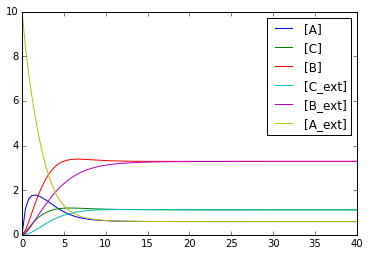

A = 0.592112863546
C = 1.11843668611
B = 3.28946472243
C_ext = 1.11846432187
B_ext = 3.28940856038
A_ext = 0.592112845674


In [12]:
from multiscale.examples.testdata import demo_filepath
# equidistant timecourse for 20 [s]

roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, False)
rr = roadrunner.RoadRunner(demo_filepath)
s = rr.simulate(0,40, 100, plot=True)  

roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, True)
rr = roadrunner.RoadRunner(demo_filepath)
s = rr.simulate(0,40, 100, plot=True)  

rr.reset()
rr.selections = ['time'] + ['[{}]'.format(s) for s in rr.model.getFloatingSpeciesIds()]
s = rr.simulate(0,40, 100, plot=True)  

for sid, value in zip(rr.model.getFloatingSpeciesIds(), rr.model.getFloatingSpeciesConcentrations()):
    print('{} = {}'.format(sid, value))

In [13]:
# Steady States
# Performs a steady state calculation (evolves the system to a steady
#        state), then calculates and returns the set of values specified by
#        the steady state selections.
print rr.selections
print rr.getSteadyStateValues()

['time', '[A]', '[C]', '[B]', '[C_ext]', '[B_ext]', '[A_ext]']
[ 0.59210526  1.11842104  3.28947365  1.11842099  3.28947373]


## Metabolic Control Analysis (MCA)

Metabolic control analysis (MCA) is a mathematical framework for describing metabolic, signaling, and genetic pathways. MCA quantifies how variables, such as fluxes and species concentrations, depend on network parameters. In particular it is able to describe how network dependent properties, called control coefficients, depend on local properties called elasticities [http://en.wikipedia.org/wiki/Metabolic_control_analysis].

### Control Coefficients

A control coefficient measures the relative steady state change in a system variable, e.g. pathway flux (J) or metabolite concentration (S), in response to a relative change in a parameter, e.g. enzyme activity or the steady-state rate ( v_i ) of step i. The two main control coefficients are the flux and concentration control coefficients. Flux control coefficients are defined by:

$$C^J_{v_i} = \left( \frac{dJ}{dp} \frac{p}{J} \right) \bigg/ \left( \frac{\partial v_i}{\partial p}\frac{p}{v_i} \right) = \frac{d\ln J}{d\ln v_i}$$

In [14]:
# Scaled control coefficient with respect to a global parameter.
rr.getCC('bA', 'Vmax_bA')

nan

In [15]:
# The n by n matrix of scaled flux control coefficients 
# where n is the number of reactions.
print('** Scaled Flux Control Coefficients **')
C_J = DataFrame(rr.getScaledFluxControlCoefficientMatrix(), \
                index=rr.model.getReactionIds(), \
                columns=rr.model.getReactionIds())
print(C_J)

** Scaled Flux Control Coefficients **
              bA            bB            bC        v1        v2        v3  \
bA  0.000000e+00 -1.947054e-17 -5.225850e-17  0.000011 -0.000000 -0.000000   
bB  0.000000e+00 -2.220446e-16  5.696703e-17 -0.000017 -0.000019  0.000036   
bC  0.000000e+00  0.000000e+00  0.000000e+00 -0.000000 -0.000000 -0.000000   
v1 -7.026713e-13  1.536106e-13  1.166178e-13  0.263158 -0.473684  0.894737   
v2 -7.026713e-13  1.536106e-13  1.166178e-13 -0.292398  0.776316  0.422515   
v3 -7.026713e-13  1.536106e-13  1.166178e-13 -0.030960  0.188080  0.644737   
v4 -7.026713e-13  1.536106e-13  1.166178e-13  0.263158 -0.473684  0.894737   

          v4  
bA -0.000009  
bB  0.000034  
bC  0.000033  
v1  0.315789  
v2  0.093567  
v3  0.198142  
v4  0.315789  


and concentration control coefficients by:

$$C^S_{v_i} = \left( \frac{dS}{dp} \frac{p}{S} \right) \bigg/ \left( \frac{\partial v_i}{\partial p} \frac{p}{v_i} \right) = \frac{d\ln S}{d\ln v_i}$$

In [16]:
# The m by n matrix of scaled concentration control coefficients where m is the number
# of floating species and n the number of reactions.
print('** Scaled Concentration Control Coefficients **')
C_S = DataFrame(rr.getScaledConcentrationControlCoefficientMatrix(), \
                index=rr.model.getFloatingSpeciesIds(), \
                columns=rr.model.getReactionIds())
print(C_S)

** Scaled Concentration Control Coefficients **
                 bA            bB            bC        v1        v2        v3  \
A     -8.741664e-10  1.918857e-10  1.445957e-10 -0.292398 -0.223684  0.422515   
C     -8.741664e-10  1.918857e-10  1.445957e-10 -0.030960  0.188080 -0.355263   
B     -8.741664e-10  1.918857e-10  1.445957e-10  0.063158 -0.023684  0.044737   
C_ext -8.741664e-10  1.918857e-10 -1.148260e-09 -0.030960  0.188080 -0.355263   
B_ext -8.741664e-10 -3.914468e-10  1.445957e-10  0.063158 -0.023684  0.044737   
A_ext  1.388953e-08  1.918857e-10  1.445957e-10 -0.292398 -0.223684  0.422515   

             v4  
A      0.093567  
C      0.198142  
B     -0.084211  
C_ext  0.198142  
B_ext -0.084211  
A_ext  0.093567  


### Summation Theorems

The flux control summation theorem was discovered independently by the Kacser/Burns group and the Heinrich/Rapoport group in the early 1970s and late 1960s. The flux control summation theorem implies that metabolic fluxes are systemic properties and that their control is shared by all reactions in the system. When a single reaction changes its control of the flux this is compensated by changes in the control of the same flux by all other reactions.

$$\sum_i C^J_{v_i} = 1$$

$$\sum_i C^S_{v_i} = 0$$

In [17]:
# Flux control coefficients have to sum to 1
print(np.sum(C_J, axis=1))
abs(np.sum(C_J, axis=1)-1) < 1E-6
# ! The three transporters do not sum up to 1

bA    0.000002
bB    0.000034
bC    0.000033
v1    1.000000
v2    1.000000
v3    1.000000
v4    1.000000
dtype: float64


bA    False
bB    False
bC    False
v1     True
v2     True
v3     True
v4     True
dtype: bool

In [18]:
# Concentration control coefficients have to sum to 0
print(np.sum(C_S, axis=1))
np.sum(C_S, axis=1) < 1E-6

A       -5.376852e-10
C       -5.376851e-10
B       -5.376851e-10
C_ext   -1.830541e-09
B_ext   -1.121018e-09
A_ext    1.422601e-08
dtype: float64


A        True
C        True
B        True
C_ext    True
B_ext    True
A_ext    True
dtype: bool

### Elasticity coefficients
Retrieve a single elasticity coefficient with respect to a global parameter.

        For example::

          x = rr.getEE ('J1', 'Vmax')

In [19]:
print(rr.model.getGlobalParameterIds())
print rr.getEE('v1', 'Vmax_v1')
print rr.getEE('v1', 'Keq_v1')

['scale_f', 'Vmax_bA', 'Km_A', 'Vmax_bB', 'Km_B', 'Vmax_bC', 'Km_C', 'Vmax_v1', 'Keq_v1', 'Vmax_v2', 'Vmax_v3', 'Vmax_v4', 'Keq_v4', 'cm_0_76fe28e0_0473_11e5_a716_9cebe809d990']
1.0
1.24996835523
